# Использование предобученных трансформеров

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

Большинство SOTA моделей последних лет основаны на 1 нейросетевой архитектуре, которая называется Transformer. Эта архитектура была представлена в 2017 году в статье - [Attention is all you need](https://arxiv.org/abs/1706.03762). 

На тот момент в обработке последовательностей доминировали рекуррентные нейроные сети, но у них была проблема с "забыванием" информации при обработке длинных текстов. Для решения этой проблемы был придуман механизм внимания (attention), который позволял на каждом шаге учитывать информацию от всех предыдущих и последующих элементов. LSTM+Attention некоторое время был sota подходом, но в attention is all you need было показано, что можно получить те же результаты, используя по сути только механизм внимания, без рекуррентности. 

Отсутствие рекуррентности позволяет гораздо эффективнее распараллеливать вычисления как на 1 gpu/tpu так и на кластере. На тот момент уже было несколько исследований показывающих, что при увеличении количества параметров и данных, модели начинают вести себя неожиданно хорошо (например, у OpenAI была статья в которой они рассказывали, что оставили LSTM на несколько месяцев и потом обнаружили, что она научилась достаточно точно определять тональность текста (без обучения на размеченном датасете) - https://openai.com/blog/unsupervised-sentiment-neuron/). Рекуррентные сети не позволяли серьезно увеличивать размер сетей даже при наличие ресурсов, а трансформеры позволили. 

Все последующие годы регулярно появлялись (и продолжают появляться) все более и более объемные трансформерные модели (BERT, GPT-1,2,3, Megatron). И каждый раз увеличение размера приводило к новым беспрецедентным результатам. 

Давайте попробуем чуть более подробно разобрать, как устроен трансформер. Это не простая тема и разбирать её мы будем постепенно.   
**В этом семинаре посмотрим в целом на архитектуру и ее ключевые элементы, а также попробуем использовать предобученные трансформерные модели для задачи классификации.**

## Seq2seq

Для начала вернемся к рекуррентным сетям. Их недостатки наиболее серьезно проявились в задаче seq2seq. В seq2seq по входной последовательности нужно сгенерировать целевую последовательность, а длины последовательностей при этом могут отличаться. Самый каноничный пример seq2seq задачи - машинный перевод.

Использование LSTM* для машинного перевода можно схематически представить вот так:

*_тут и далее когда я говорю LSTM я на самом деле подразумеваю рекуррентные нейроные сети в целом, просто LSTM самый популярный их представитель, но уточнять это каждый раз неудобно_

In [21]:
Image(url="https://i.ibb.co/XjP2Gmh/Lstm-seq2seq.png", width=700, height=500)

Для такой задачи нужно два LSTM слоя: один кодирует входную последовательность (encoder, или кодировщик), другой генерирует целевую последовательность (decoder или декодировщик). Такой подход работает, но есть серьезный недостаток - на вход декодеру подается только 1 вектор, в котором закодирована вся информация о целевой последовательности. Этот вектор - бутылочное горлышко (botleneck), узкое место, в которое все упирается.

Если приводить аналогии, это как пытаться первести текст сходу целиком, прочитав его только 1 раз (попробуйте, например, перевести это предложение, не перечитывая). 

### Attention

Для устранения бутылочного горлышка стали использовать механизм внимания. Он дает декодирующей LSTM доступ ко всем состояниям энкодера, а не только к последнему. Это уже больше похоже на то, как человек переводит текст - текст прочитывается целиком, но при переводе можно возвращаться к каждому отдельному слову исходного текста.   

Схематично LSTM+Attention можно представить вот так. Такая архитектура уже в середине десятых годов позволила Google начать переход к нейронному переводу (до этого использовался статистический и правиловый):

In [14]:
Image(url="https://i.ibb.co/bzwNqwC/lstm-attention-seq2seq.png",
     width=600, height=500)

Давайте подробнее посмотрим на механизм внимания. Визуализировать его целиком достаточно сложно, поэтому рассмотрим только 1 шаг (генерацию первого слова в переводе). 

In [19]:
Image(url="https://i.ibb.co/19xB94B/lstm-attention-1-step.png",
     width=700, height=600)

Само внимание (или attention) можно реализовать разными способами. Мы рассмотрим один возможный подход - через скалярное произведение. 

После прохода энкодера для каждого элемента входной последовательности существует вектор состояния (его можно считать контекстным эмбедингом слова). На каждом шаге декодера между текущим состоянием декодера и всеми состояними энкодера расчитывается скалярное произведение (можно сказать считается близость между переводным словом и всеми словами входного текста). Результатом такого скалярного произведения является набор весов, соответствующих каждому слову входной последовательности. Эти веса показывают, какие слова релеванты для генерации текущего слова в переводе. 

Далее каждый вес умножается на соотвутсвующий ему вектор состояния энкодера и эти вектора прибавляются к текущему состоянию декодера (то есть происходит взвешенная сумма векторов слов входной последовательности и итоговая сумма прибавляется или конкатенируется к состояние декодера). 

Attention убрал существующий bottleneck, но обучать такие модели было очень тяжело, так как в основе был LSTM. В 2017 был предложен подход без использования LSTM - Transformer.

## Transformer 

Вот как схематично решается задача машинного перевода с помощью трансформера. Самим трансформером называется блок с вниманием и полносвязными слоями, то есть и энкодер и декодер состоят из идентичных трансформерных блоков. Как и другие слои - трансформерные блоки можно накладывать друг на друга. Количество таких блоков в энкодере и декодере - настраиваемый гиперпараметр модели. 

In [3]:
Image(url="https://i.ibb.co/XY0GK2R/transformer.png", width=700, height=500)

В трансформерных блоках также есть нормализация и skip-связи, но пока мы их пропустим. 

Attention в трансформере конечно не такой простой как на примере выше. Давайте посмотрим на визуализацию из вот этого поста https://jalammar.github.io/illustrated-transformer/ (его имеет смысл почитать целиком)

Attention также вычисляется через скалаярное произведение, но оно считается не между векторами напрямую. 

Каждый эмбединг одтельного слова преобразуется в 3 отдельных вектора с помощью полносвязного слоя (умножения на матрицу). У них есть названия: query вектор, key вектор и value вектор. 

In [8]:
Image(url="https://jalammar.github.io/images/t/transformer_self_attention_vectors.png", width=400, height=400)

Attention score вычисляется с помощью скалярного произведения query вектора текущего слова и key векторов всех слов в последовательности. Результат скалярного произведения пропускается через softmax, чтобы получить вероятности (это и есть оценки внимания, attention scores, высокая вероятность означает, что на это слово нужно обратить внимание, а низкий - что слово на текущем шаге не важно). 

Далее выполняется взвешенная сумма всех value векторов (веса = attention скоры). Полученный вектор уже передается дальше в полносвязный слой. При наслаивании транформерных блоков друг на друга на втором слое вместо эмбединга слова уже будет использоваться вектор полученный из предыдущего блока.

In [9]:
Image(url="https://jalammar.github.io/images/t/self-attention-output.png", width=400, height=400)

Но это еще не все. Это пример того, что называется self-attention - когда внимание расчитыватся между элементами одной последовательности. На схеме выше еще есть cross-attention. Он используется в декодере - query вектор тут получается из эмбедингов слов в целевой последовательности, а key и value вектора получаются из выходных векторов энкодера. Cross-attention связывает энкодер и декодер.

Self-attention также присутствует в декодере. При обучении seq2seq моделей на вход подаются сразу две последовательности (текст и его перевод, например), но целевая последовательность подается постепенно (по 1 слову) и задача декодера - по полной входной последовательности и имеющейся на данный момент целевой последовательности сгенерировать продолжение. При использовании обученной модели для перевода текста сначала в декодер передается пустая последовательсть (а точнее не пустая а с тегом SOS или start, можно тут вспомнить семинар по языковым моделям).

#### Positional embedding

Еще одна важная составляющая транформера - positinal encoding (на схеме вместо обычного emded - pos emded), позиционной кодирование. Механизм внимания ничего не знает о позиции слов, он рассматривает последовательность как мешок слов, а от LSTM мы избавились. Поэтому нужно как-то закодировать информацию о последовательности в эмбединги слов. В Attention is all you need это было сделано простым добавлением к эмбедингу слова вектора, который зависит от индекса слова в последовательности. В статье они использовали периодичные функции (синус и косинус), которые не нужно обучать - они просто возвращают какое-то значение на каждый индекс последовательности. Количество уникальных векторов генерируемых таким образом конечно ограничено, но очень большое количество и не требуется, так как транформер сам по себе не очень хорошо масштабируется на длинные последовательности (обычно ограниченивают максимальную длину около 512).

Вот визуализация позиционных векторов из того же поста (изображено 20 векторов - по строкам, каждый размерности 512 - колонки; видно как вектора меняются при увеличении индекса):

In [13]:
Image(url="https://jalammar.github.io/images/t/transformer_positional_encoding_large_example.png", 
      width=700, height=500)


В трансформере еще много других технических деталей, но для использования пока будет достаточно интуитивного понимания.

## Использование предобученных моделей

С появлением предобученных трансформеных моделей развился transfer learning - это использование моделей для задач, решать которые они изначально не обучались. 

Большинство предобученных моделей - языковые модели, которые обучались просто продолжать текст или заполнять в нем пропуски. Эмбединги, которые генерирует энкодер таких предобученных моделей уже очень хорошо улавливают смысл и их можно напрямую использовать для классифицикаии. А можно еще немного дообучить весь энкодер на доступных размеченных данных и получить еще лучший результат. Так как в модели уже много знаний, для дообучения нужно буквально несколько примеров. 

Давайте посмотрим на разницу в качестве дообученной модели и обученной с нуля на имеющихся данных.

In [1]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# tf и huggingface 
import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer


Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

In [8]:
# data_frac = pd.concat([data[data.topic=='Россия'].sample(frac=0.001),
#                       data[data.topic=='Мир'].sample(frac=0.001),
#                       data[data.topic=='Экономика'].sample(frac=0.002),
#                       data[data.topic=='Спорт'].sample(frac=0.003),
#                       data[data.topic=='Наука и техника'].sample(frac=0.005),
#                       data[data.topic=='Бывший СССР'].sample(frac=0.005),
#                       data[data.topic=='Культура'].sample(frac=0.005),
#                       data[data.topic=='Интернет и СМИ'].sample(frac=0.005),
#                       data[data.topic=='Из жизни'].sample(frac=0.01),
#                       data[data.topic=='Дом'].sample(frac=0.01),
#                       data[data.topic=='Силовые структуры'].sample(frac=0.01),
#                       data[data.topic=='Ценности'].sample(frac=0.03),
#                       data[data.topic=='Бизнес'].sample(frac=0.03),
#                       data[data.topic=='69-я параллель'].sample(frac=0.05),
#                       data[data.topic=='Крым'].sample(frac=0.05),
#                       data[data.topic=='Культпросвет'].sample(frac=0.2),
#                       data[data.topic=='Легпром'].sample(frac=0.8),
#                       data[data.topic=='Библиотека']]).reset_index(drop=True)

In [7]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [10]:
data.topic.value_counts()

Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

In [11]:
data.shape

(607, 6)

### Загружаем предобученную модель из huggingface transformers

Список всех доступных моделей можно найти тут - https://huggingface.co/models  
А вот тут основные с описанием - https://huggingface.co/transformers/pretrained_models.html

На HG предпочитают торч, поэтому многие модели не загрузятся в тф. Там есть специальный тэг, по которому можно фильтровать модели. 

Виды моделей мы обсудим на следующем занятии, так как их очень много и они существенно отличаются друг от друга. Пока разберем 3 варианта одной из первых предобученных моделей - BERT. 

In [7]:
# # Можно сказать оригинальный берт
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# model_bert = AutoModel.from_pretrained('bert-base-cased')

In [10]:
# # Мультиязычный берт
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [43]:
# # # Rubert который есть на тф от неизвестного пользователя геотренд
# tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")
# model_bert = TFAutoModel.from_pretrained("Geotrend/bert-base-ru-cased")

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Мы загружаем не только модель, а еще и токенайзер, т.е. свою предобработку нам писать не нужно

In [11]:
data.loc[4, 'title']

'Рыбкин поможет Хакамаде стать президентом России'

Перевести токены в индексы очень просто

In [12]:
tokenizer.encode(data.loc[4, 'title'])

[101,
 525,
 10292,
 67725,
 10267,
 96358,
 104998,
 530,
 34411,
 73287,
 10205,
 50121,
 48841,
 12152,
 102]

В этих моделях как правило используется BPE

In [13]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'Р',
 '##ы',
 '##бки',
 '##н',
 'пом',
 '##ожет',
 'Х',
 '##ака',
 '##мад',
 '##е',
 'стать',
 'президентом',
 'России',
 '[SEP]']

Индексы можно напрямую передавать в модель.

In [14]:
text = data.loc[4, 'title']
text_ids = tf.constant([tokenizer.encode(text, add_special_tokens=True)])
output = model_bert(text_ids, output_attentions=False)

На выходе мы получим tuple из двух элементов. 

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [15]:
output[0].shape # в пайторче вместо .shape используется size()

TensorShape([1, 15, 768])

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [16]:
output[1].shape

TensorShape([1, 768])

Обычно в задачах используют либо состояние первого элемента

In [17]:
output[0][:,0].shape

TensorShape([1, 768])

Либо усредненное состояние 

In [18]:
tf.math.reduce_mean(output[0], axis=1).shape

TensorShape([1, 768])

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Давайте попробуем дообучить (fine-tune) модель на данных lenta ru

Будем обучаться на заголовках, а не на самих текстах

In [20]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)
    
    X.append(ids[:512])

In [21]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [22]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [23]:
X.shape

(607, 512)

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [24]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [25]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [37]:

input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})

# добавим дропаут чтобы не переобучалось
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

# лосс нужно поставить поменьше
model_clf.compile(tf.optimizers.Adam(lr=2e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80)])




С батчсайзом тут приходится уже быть осторожным, т.к. берт занимает очень много места на видеокарте. 

In [38]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=16,
         epochs=20)

Epoch 1/20
36/36 [==============================] - 47s 648ms/step - loss: 2.9986 - accuracy: 0.1233 - f1: 0.0064 - val_loss: 2.4953 - val_accuracy: 0.1935 - val_f1: 0.0000e+00
Epoch 2/20
36/36 [==============================] - 16s 442ms/step - loss: 1.9715 - accuracy: 0.4132 - f1: 0.1411 - val_loss: 1.8663 - val_accuracy: 0.4839 - val_f1: 0.1181
Epoch 3/20
36/36 [==============================] - 16s 447ms/step - loss: 1.3084 - accuracy: 0.6615 - f1: 0.4522 - val_loss: 1.5755 - val_accuracy: 0.5806 - val_f1: 0.4188
Epoch 4/20
36/36 [==============================] - 16s 451ms/step - loss: 0.9227 - accuracy: 0.7934 - f1: 0.6675 - val_loss: 1.4404 - val_accuracy: 0.6129 - val_f1: 0.5473
Epoch 5/20
36/36 [==============================] - 16s 446ms/step - loss: 0.6839 - accuracy: 0.8542 - f1: 0.7956 - val_loss: 1.3580 - val_accuracy: 0.6129 - val_f1: 0.5994
Epoch 6/20
36/36 [==============================] - 16s 451ms/step - loss: 0.5661 - accuracy: 0.8872 - f1: 0.8277 - val_loss: 1.330

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1'])


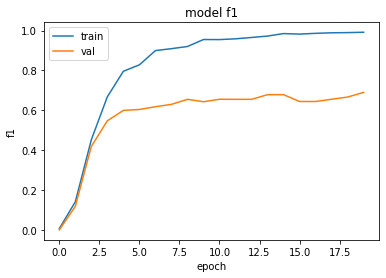

In [44]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['f1'])
plt.plot(model_clf.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
from sklearn.metrics import classification_report

In [48]:
pred = model_clf.predict(X_valid).argmax(1)

In [55]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

            Спорт       1.00      1.00      1.00         2
         Ценности       1.00      0.50      0.67         2
          Легпром       0.00      0.00      0.00         1
              Дом       0.67      1.00      0.80         2
   Интернет и СМИ       0.50      0.50      0.50         2
         Культура       1.00      1.00      1.00         3
        Экономика       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
   69-я параллель       1.00      1.00      1.00         1
           Россия       1.00      1.00      1.00         2
      Бывший СССР       0.40      0.67      0.50         3
       Библиотека       0.00      0.00      0.00         0
  Наука и техника       0.75      1.00      0.86         3
         Из жизни       0.50      0.33      0.40         3
Силовые структуры       0.50      0.50      0.50         2
              Мир       0.00      0.00      0.00       

Ф-мера в 65 выглядит не очень, но нужно помнить, что мы обучились на 600 примерах. Для сравнения можно попробовать обучить лстм на тех же данных.

In [60]:

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

vocab = Counter()

for text in data.title:
    vocab.update(preprocess(text))

# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in data.title:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)


# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=MAX_LEN)


id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=data.topic)

In [61]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])


In [62]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 13, 30)            92580     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               81408     
_________________________________________________________________
dense_3 (Dense)              (None, 17)                2193      
Total params: 176,181
Trainable params: 176,181
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

Epoch 1/50
18/18 [==============================] - 1s 42ms/step - loss: 0.5776 - accuracy: 0.8108 - f1: 0.8024 - val_loss: 5.0685 - val_accuracy: 0.1613 - val_f1: 0.1818
Epoch 2/50
18/18 [==============================] - 1s 44ms/step - loss: 0.4634 - accuracy: 0.8611 - f1: 0.8810 - val_loss: 5.4626 - val_accuracy: 0.1935 - val_f1: 0.2105
Epoch 3/50
18/18 [==============================] - 1s 49ms/step - loss: 0.3959 - accuracy: 0.8802 - f1: 0.8930 - val_loss: 5.5292 - val_accuracy: 0.1935 - val_f1: 0.2034
Epoch 4/50
18/18 [==============================] - 1s 36ms/step - loss: 0.4465 - accuracy: 0.8490 - f1: 0.8561 - val_loss: 5.5703 - val_accuracy: 0.1613 - val_f1: 0.1786
Epoch 5/50
18/18 [==============================] - 1s 28ms/step - loss: 0.4964 - accuracy: 0.8403 - f1: 0.8439 - val_loss: 5.1263 - val_accuracy: 0.2258 - val_f1: 0.2333
Epoch 6/50
18/18 [==============================] - 1s 31ms/step - loss: 0.4767 - accuracy: 0.8264 - f1: 0.8378 - val_loss: 5.3636 - val_accuracy

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1'])


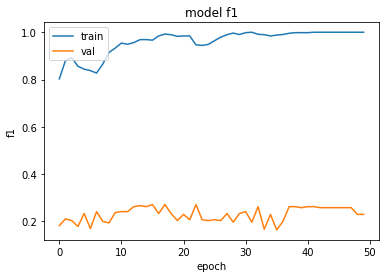

In [66]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Модель очень сильно переобучается. Она полностью выучивает обучающую выборку, но с предсказанием новых данных все очень плохо (разрыв в качестве с предобученной моделью огромный). Увеличение количества параметров не поможет - будет точно такая же картина. Для того, чтобы увеличить качество необходимо больше данных. 